# MindSpore实战一，MNIST手写体识别

数据集介绍：
* MNIST数据集来自美国国家标准与技术研究所，National Institute of Standards and Technology(NIST),数据集由来自250个不同人手写的数字构成，其中50%是高中学生，50%来自人口普查局（the Census Bureau）的工作人员。

* 训练集：60000，测试集：10000

* MNIST数据集可在 http://yann.lecun.com/exdb/mnist/ 获取。

本实验使用MindSpore深度学习框架，进行网络搭建、数据处理、网络训练和测试，完成MNIST手写体识别任务。

实验流程：

<img src="image/02.png">

## 环境准备
* MindSpore模块主要用于本次实验卷积神经网络的构建，包括很多子模块。
    * mindspore.dataset：包括MNIST数据集的载入与处理，也可以自定义数据集。

    * mindspore.common：包中会有诸如type形态转变、权重初始化等的常规工具。

    * mindspore.nn：主要包括网络可能涉及到的各类网络层，诸如卷积层、池化层、全连接层，也包括损失函数，激活函数等。
    
    * Model：承载网络结构，并能够调用优化器、损失函数、评价指标。


本实验需要以下第三方库：
1. MindSpore 1.1.1
2. Numpy 1.17.5

In [1]:
# mindspore.dataset
import mindspore.dataset as ds # 数据集的载入
import mindspore.dataset.transforms.c_transforms as C # 常用转化算子
import mindspore.dataset.vision.c_transforms as CV # 图像转化算子

# mindspore.common
from mindspore.common import dtype as mstype # 数据形态转换
from mindspore.common.initializer import Normal # 参数初始化

# mindspore.nn
import mindspore.nn as nn # 各类网络层都在nn里面
from mindspore.nn.metrics import Accuracy # 测试模型用


from mindspore import Model # 承载网络结构


# os模块处理数据路径用
import os

# numpy
import numpy as np

## 数据处理

定义数据预处理函数。

函数功能包括：
1. 加载数据集
1. 打乱数据集
1. 图像特征处理（标准化、通道转换等）
3. 批量输出数据
4. 重复

In [2]:
def create_dataset(data_path, batch_size=32):
    """ 
    数据预处理与批量输出的函数
    
    Args:
        data_path: 数据路径
        batch_size: 批量大小
    """
    
    # 定义数据集
    data = ds.MnistDataset(data_path)
    
    # 打乱数据集
    data = data.shuffle(buffer_size=10000)
    
    # 数据标准化参数
    # MNIST数据集的 mean = 33.3285，std = 78.5655
    mean, std = 33.3285, 78.5655 

    # 定义算子
    nml_op = lambda x : np.float32((x-mean)/std) # 数据标准化，image = (image-mean)/std
    hwc2chw_op = CV.HWC2CHW() # 通道前移（为配适网络，CHW的格式可最佳发挥昇腾芯片算力）
    type_cast_op = C.TypeCast(mstype.int32) # 原始数据的标签是unint，计算损失需要int

    # 算子运算
    data = data.map(operations=type_cast_op, input_columns='label')
    data = data.map(operations=nml_op, input_columns='image')
    data = data.map(operations=hwc2chw_op, input_columns='image')

    # 批处理
    data = data.batch(batch_size)
    
    # 重复
    data = data.repeat(1)

    return data

## 网络定义
### 参考LeNet网络结构，构建网络
LeNet-5出自论文《Gradient-Based Learning Applied to Document Recognition》，原本是一种用于手写体字符识别的非常高效的卷积神经网络，包含了深度学习的基本模块：卷积层，池化层，全连接层。

本实验将参考LeNet论文，建立以下网络：
<img src="image/03.png">

1.	INPUT（输入层） ：输入28∗28的图片。
2.	C1（卷积层）：选取6个5∗5卷积核(不包含偏置)，得到6个特征图，每个特征图的一个边为28−5+1=24。
3.	S2（池化层）：池化层是一个下采样层，输出12∗12∗6的特征图。
4.	C3（卷积层）：选取16个大小为5∗5卷积核，得到特征图大小为8∗8∗16。
5.	S4（池化层）：窗口大小为2∗2，输出4∗4∗16的特征图。
6.	F5（全连接层）：120个神经元。
7.	F6（全连接层）：84个神经元。
8.	OUTPUT（输出层）：10个神经元，10分类问题。


In [3]:
class LeNet5(nn.Cell):
    
    # 定义算子
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        
        # 全连接层
        self.fc1 = nn.Dense(4 * 4 * 16, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        
        # 激活函数
        self.relu = nn.ReLU()
        
        # 最大池化层
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 网络展开
        self.flatten = nn.Flatten()
        
    # 建构网络
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x 

## 模型训练

载入数据集

In [4]:
train_path = os.path.join('data','train') # 训练集路径
train_data = create_dataset(train_path) # 定义训练数据集

test_path = os.path.join('data','test') # 测试集路径
test_data = create_dataset(test_path) # 定义测试数据集

定义网络、损失函数、优化器、模型

In [5]:
# 网络
net = LeNet5()

# 损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 优化器
lr = 0.01
momentum = 0.9
net_opt = nn.Momentum(net.trainable_params(), lr, momentum)

# 模型
model = Model(net, net_loss, net_opt, metrics={'accuracy': Accuracy()})

训练模型

In [6]:
model.train(3, train_data) # 训练3个epoch

[WARNING] ME(13516:456,MainProcess):2022-01-04-17:58:00.365.818 [mindspore\train\model.py:412] The CPU cannot support dataset sink mode currently.So the training process will be performed with dataset not sink.


## 模型评估
查看模型在测试集的准确率

In [7]:
model.eval(test_data) # 测试网络

[WARNING] ME(13516:456,MainProcess):2022-01-04-17:59:38.493.0 [mindspore\train\model.py:751] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


{'accuracy': 0.9809}

## 效果展示

In [8]:
data_path=os.path.join('data', 'test')

ds_test_demo = create_dataset(test_path, batch_size=1)

for i, dic in enumerate(ds_test_demo.create_dict_iterator()):
    input_img = dic['image']
    output = model.predict(input_img)
    predict = np.argmax(output.asnumpy(),axis=1)[0]
    if i>9:
        break
    print('True: %s, Predicted: %s'%(dic['label'], predict))

True: [8], Predicted: 8
True: [2], Predicted: 2
True: [4], Predicted: 4
True: [0], Predicted: 0
True: [4], Predicted: 4
True: [8], Predicted: 8
True: [9], Predicted: 9
True: [5], Predicted: 5
True: [4], Predicted: 4
True: [9], Predicted: 9


## 思考
1. 请描述MindSpore的基础数据处理流程。
    * 答：数据加载 > shuffle > map > batch > repeat
2. 定义网络时需要继承哪一个基类？
    * 答：mindspore.nn.Cell
3. 定义网络时有哪些必须编写哪两个函数？
    * 答：\_\_init__()，construct()。
4. 思考3中提到的两个函数有什么用途？
    * 答：一般会在\_\_init__()中定义算子，然后在construct()中定义网络结构。\_\_init__()中的语句由Python解析执行；construct()中的语句由MindSpore接管，有语法限制；

## 模型保存

In [10]:
from mindspore import save_checkpoint,load_checkpoint, load_param_into_net
save_checkpoint(net,"lenet5.ckpt")

## 模型加载

In [2]:
from mindspore import nn
class LeNet5(nn.Cell):
    # 定义算子
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        
        # 全连接层
        self.fc1 = nn.Dense(4 * 4 * 16, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        
        # 激活函数
        self.relu = nn.ReLU()
        
        # 最大池化层
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 网络展开
        self.flatten = nn.Flatten()
        
    # 建构网络
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x 

In [8]:
from mindspore import load_checkpoint, load_param_into_net
from mindspore.common.initializer import Normal
from mindspore import Model
from mindspore.nn.metrics import Accuracy # 测试模型用
# 加载已经保存的用于测试的模型
param_dict = load_checkpoint("lenet5.ckpt")
# 加载参数到网络中
net = LeNet5()
load_param_into_net(net, param_dict)
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
model = Model(net, net_loss, metrics={'accuracy': Accuracy()}) 

## 对抗攻击

对抗样本定义
Szegedy在2013年最早提出对抗样本的概念：在原始样本处加入人类无法察觉的微小扰动，使得深度模型性能下降，这种样本即对抗样本。  
如下图所示，本来预测为“panda”的图像在添加噪声之后，模型就将其预测为“gibbon”，右边的样本就是一个对抗样本：  
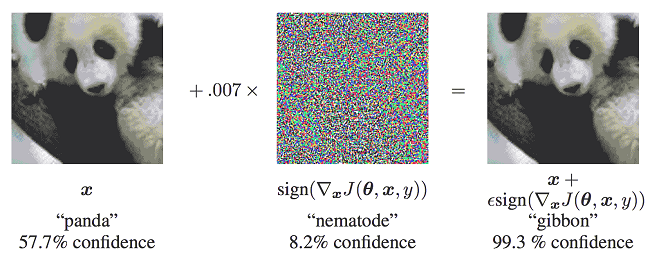

对模型的攻击方法可以按照以下方法分类：

* 攻击者掌握的信息多少：

白盒攻击：攻击者具有对模型的全部知识和访问权限，包括模型结构、权重、输入、输出。攻击者在产生对抗性攻击数据的过程中能够与模型系统有所交互。攻击者可以针对被攻击模型的特性设计特定的攻击算法。

黑盒攻击：与白盒攻击相反，攻击者仅具有关于模型的有限知识。攻击者对模型的结构权重一无所知，仅了解部分输入输出。

* 攻击者的目的：

有目标的攻击：攻击者将模型结果误导为特定分类。

无目标的攻击：攻击者只想产生错误结果，而不在乎新结果是什么。

本案例中用到的FGSM是一种白盒攻击方法，既可以是有目标也可以是无目标攻击。

更多的模型安全功能可参考**MindArmour**，现支持FGSM、LLC、Substitute Attack等多种对抗样本生成方法，并提供对抗样本鲁棒性模块、Fuzz Testing模块、隐私保护与评估模块，帮助用户增强模型安全性。

快速梯度符号攻击（FGSM）
正常分类网络的训练会定义一个损失函数，用于衡量模型输出值与样本真实标签的距离，通过反向传播计算模型梯度，梯度下降更新网络参数，减小损失值，提升模型精度。

FGSM（Fast Gradient Sign Method）是一种简单高效的对抗样本生成方法。不同于正常分类网络的训练过程，FGSM通过计算loss对于输入的梯度∇xJ(θ,x,y)，这个梯度表征了loss对于输入变化的敏感性。然后在原始输入加上上述梯度，使得loss增大，模型对于改造后的输入样本分类效果变差，达到攻击效果。对抗样本的另一要求是生成样本与原始样本的差异要尽可能的小，使用sign函数可以使得修改图片时尽可能的均匀。

产生的对抗扰动用公式可以表示为：

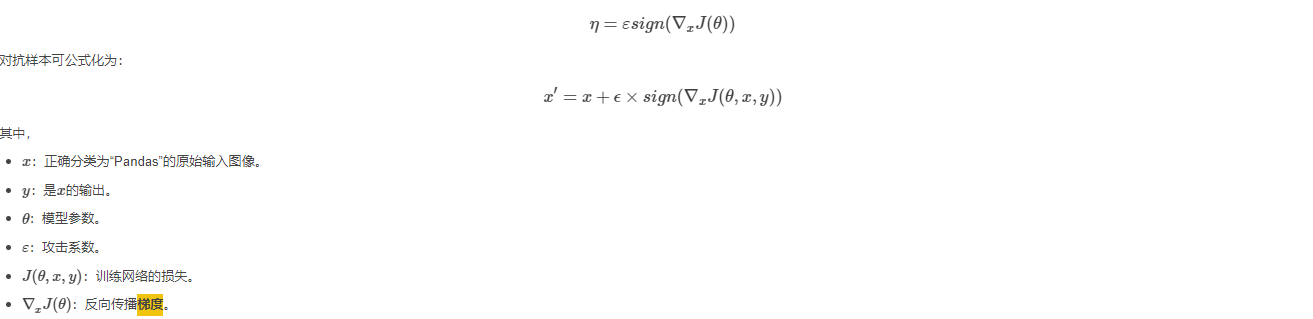

In [24]:
import mindspore.ops as ops
from mindspore import Tensor
class WithLossCell(nn.Cell):
    """
    包装网络与损失函数
    """
    def __init__(self, network, loss_fn):
        super(WithLossCell, self).__init__()
        self._network = network
        self._loss_fn = loss_fn

    def construct(self, data, label):
        out = self._network(data)
        return self._loss_fn(out, label)


class GradWrapWithLoss(nn.Cell):
    """
    通过loss求反向梯度
    """
    def __init__(self, network):
        super(GradWrapWithLoss, self).__init__()
        self._grad_all = ops.composite.GradOperation(get_all=True, sens_param=False)
        self._network = network

    def construct(self, inputs, labels):
        gout = self._grad_all(self._network)(inputs, labels)
        return gout[0]

In [12]:
class FastGradientSignMethod:
    """
    实现FGSM攻击
    """
    def __init__(self, network, eps=0.07, loss_fn=None):
        # 变量初始化
        self._network = network
        self._eps =  eps
        with_loss_cell = WithLossCell(self._network, loss_fn)
        self._grad_all = GradWrapWithLoss(with_loss_cell)
        self._grad_all.set_train()


    def _gradient(self, inputs, labels):
        # 求取梯度
        out_grad = self._grad_all(inputs, labels)
        gradient = out_grad.asnumpy()
        gradient = np.sign(gradient)
        return gradient

    def generate(self, inputs, labels):
        # 实现FGSM
        inputs_tensor = Tensor(inputs)
        labels_tensor = Tensor(labels)
        gradient = self._gradient(inputs_tensor, labels_tensor)
        # 产生扰动
        perturbation = self._eps*gradient
        # 生成受到扰动的图片
        adv_x = inputs + perturbation
        return adv_x

    def batch_generate(self, inputs, labels, batch_size=32):
        # 对数据集进行处理
        arr_x = inputs
        arr_y = labels
        len_x = len(inputs)
        batches = int(len_x / batch_size)
        rest = len_x - batches*batch_size
        res = []
        for i in range(batches):
            x_batch = arr_x[i*batch_size: (i + 1)*batch_size]
            y_batch = arr_y[i*batch_size: (i + 1)*batch_size]
            adv_x = self.generate(x_batch, y_batch)
            res.append(adv_x)
        adv_x = np.concatenate(res, axis=0)
        return adv_x

In [14]:
def create_dataset(data_path, batch_size=32):
    """ 
    数据预处理与批量输出的函数
    
    Args:
        data_path: 数据路径
        batch_size: 批量大小
    """
    
    # 定义数据集
    data = ds.MnistDataset(data_path)
    
    # 打乱数据集
    data = data.shuffle(buffer_size=10000)
    
    # 数据标准化参数
    # MNIST数据集的 mean = 33.3285，std = 78.5655
    mean, std = 33.3285, 78.5655 

    # 定义算子
    nml_op = lambda x : np.float32((x-mean)/std) # 数据标准化，image = (image-mean)/std
    hwc2chw_op = CV.HWC2CHW() # 通道前移（为配适网络，CHW的格式可最佳发挥昇腾芯片算力）
    type_cast_op = C.TypeCast(mstype.int32) # 原始数据的标签是unint，计算损失需要int

    # 算子运算
    data = data.map(operations=type_cast_op, input_columns='label')
    data = data.map(operations=nml_op, input_columns='image')
    data = data.map(operations=hwc2chw_op, input_columns='image')

    # 批处理
    data = data.batch(batch_size)
    
    # 重复
    data = data.repeat(1)

    return data

In [22]:
import os
import mindspore.dataset as ds # 数据集的载入
import mindspore.dataset.transforms.c_transforms as C # 常用转化算子
import mindspore.dataset.vision.c_transforms as CV # 图像转化算子
from mindspore.common import dtype as mstype # 数据形态转换
import numpy as np

train_path = os.path.join('data','train') # 训练集路径
train_data = create_dataset(train_path) # 定义训练数据集

test_path = os.path.join('data','test') # 测试集路径
test_data = create_dataset(test_path) # 定义测试数据集

In [25]:
images = []
labels = []
test_images = []
test_labels = []
predict_labels = []

ds_test = create_dataset(test_path).create_dict_iterator(output_numpy=True)

for data in ds_test:
    images = data['image'].astype(np.float32)
    labels = data['label']
    test_images.append(images)
    test_labels.append(labels)
    pred_labels = np.argmax(model.predict(Tensor(images)).asnumpy(), axis=1)
    predict_labels.append(pred_labels)

test_images = np.concatenate(test_images)
predict_labels = np.concatenate(predict_labels)
true_labels = np.concatenate(test_labels)

In [26]:
fgsm = FastGradientSignMethod(net, eps=0.0, loss_fn=net_loss)
advs = fgsm.batch_generate(test_images, true_labels, batch_size=32)

adv_predicts = model.predict(Tensor(advs)).asnumpy()
adv_predicts = np.argmax(adv_predicts, axis=1)
accuracy = np.mean(np.equal(adv_predicts, true_labels[:9984]))
print(accuracy)

0.9797676282051282


In [28]:
fgsm = FastGradientSignMethod(net, eps=0.5, loss_fn=net_loss)
advs = fgsm.batch_generate(test_images, true_labels, batch_size=32)

adv_predicts = model.predict(Tensor(advs)).asnumpy()
adv_predicts = np.argmax(adv_predicts, axis=1)
accuracy = np.mean(np.equal(adv_predicts, true_labels[:9984]))
print(accuracy)

0.38591746794871795


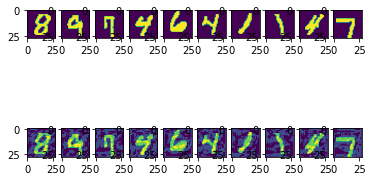

In [29]:
import matplotlib.pyplot as plt

adv_examples = np.transpose(advs[:10],[0,2,3,1])
ori_examples = np.transpose(test_images[:10],[0,2,3,1])

plt.figure()
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(ori_examples[i])
    plt.subplot(2,10,i+11)
    plt.imshow(adv_examples[i])

## 数据增强

In [1]:
import os
import os
import mindspore.dataset as ds # 数据集的载入
import mindspore.dataset.transforms.c_transforms as C # 常用转化算子
import mindspore.dataset.vision.c_transforms as CV # 图像转化算子
from mindspore.common import dtype as mstype # 数据形态转换
import numpy as np
train_path = os.path.join('data','train') # 训练集路径
#train_data = create_dataset(train_path) # 定义训练数据集

test_path = os.path.join('data','test') # 测试集路径
# test_data = create_dataset(test_path) # 定义测试数据集

In [2]:
import mindspore.dataset.vision.c_transforms as CV
from mindspore.common import dtype as mstype
import mindspore.dataset.transforms.c_transforms as C

def create_aug_dataset1(data_path, batch_size=32):
    
    # 定义数据集
    data = ds.MnistDataset(data_path)
    
    # 打乱数据集
    # data = data.shuffle(buffer_size=10000)
    
    # 数据标准化参数
    # MNIST数据集的 mean = 33.3285，std = 78.5655
    mean, std = 33.3285, 78.5655 

    # 定义算子
    nml_op = lambda x : np.float32((x-mean)/std) 
    hwc2chw_op = CV.HWC2CHW() 
    type_cast_op = C.TypeCast(mstype.int32)
    pad_op1 = CV.Pad([3,3,3,3])
    pad_op2 = CV.Pad([6,6,6,6])
    # random_rot_op = CV.RandomRotation(degrees=15.0)
    resize_crop_op = CV.RandomResizedCrop(size=(28, 28), scale=(0.75, 1.0))
    # randomaffine_op = CV.RandomAffine(degrees=15,
    #                                  scale=(1.0, 1.0))
    c_trans1 = [resize_crop_op,hwc2chw_op]
    c_trans2 = [pad_op1,resize_crop_op,hwc2chw_op]
    c_trans3 = [pad_op2,resize_crop_op,hwc2chw_op]

    # 算子运算
    data = data.map(operations=type_cast_op, input_columns='label')
    data = data.map(operations=nml_op, input_columns='image')
    data = data.map(operations=c_trans1, input_columns='image')

    # 批处理
    data = data.batch(batch_size)

    return data

def create_aug_dataset2(data_path, batch_size=32):
    
    # 定义数据集
    data = ds.MnistDataset(data_path)
    
    # 打乱数据集
    # data = data.shuffle(buffer_size=10000)
    
    # 数据标准化参数
    # MNIST数据集的 mean = 33.3285，std = 78.5655
    mean, std = 33.3285, 78.5655 

    # 定义算子
    nml_op = lambda x : np.float32((x-mean)/std) 
    hwc2chw_op = CV.HWC2CHW() 
    type_cast_op = C.TypeCast(mstype.int32)
    pad_op1 = CV.Pad([3,3,3,3])
    pad_op2 = CV.Pad([6,6,6,6])
    # random_rot_op = CV.RandomRotation(degrees=15.0)
    resize_crop_op = CV.RandomResizedCrop(size=(28, 28), scale=(0.75, 1.0))
    # randomaffine_op = CV.RandomAffine(degrees=15,
    #                                  scale=(1.0, 1.0))
    c_trans1 = [resize_crop_op,hwc2chw_op]
    c_trans2 = [pad_op1,resize_crop_op,hwc2chw_op]
    c_trans3 = [pad_op2,resize_crop_op,hwc2chw_op]

    # 算子运算
    data = data.map(operations=type_cast_op, input_columns='label')
    data = data.map(operations=nml_op, input_columns='image')
    data = data.map(operations=c_trans2, input_columns='image')

    # 批处理
    data = data.batch(batch_size)

    return data

def create_aug_dataset3(data_path, batch_size=32):
    
    # 定义数据集
    data = ds.MnistDataset(data_path)
    
    # 打乱数据集
    # data = data.shuffle(buffer_size=10000)
    
    # 数据标准化参数
    # MNIST数据集的 mean = 33.3285，std = 78.5655
    mean, std = 33.3285, 78.5655 

    # 定义算子
    nml_op = lambda x : np.float32((x-mean)/std) 
    hwc2chw_op = CV.HWC2CHW() 
    type_cast_op = C.TypeCast(mstype.int32)
    pad_op1 = CV.Pad([3,3,3,3])
    pad_op2 = CV.Pad([6,6,6,6])
    # random_rot_op = CV.RandomRotation(degrees=15.0)
    resize_crop_op = CV.RandomResizedCrop(size=(28, 28), scale=(0.75, 1.0))
    # randomaffine_op = CV.RandomAffine(degrees=15,
    #                                  scale=(1.0, 1.0))
    c_trans1 = [resize_crop_op,hwc2chw_op]
    c_trans2 = [pad_op1,resize_crop_op,hwc2chw_op]
    c_trans3 = [pad_op2,resize_crop_op,hwc2chw_op]

    # 算子运算
    data = data.map(operations=type_cast_op, input_columns='label')
    data = data.map(operations=nml_op, input_columns='image')
    data = data.map(operations=c_trans3, input_columns='image')

    # 批处理
    data = data.batch(batch_size)

    return data

In [37]:
from matplotlib import pyplot as plt

mnist_dataset1 = create_aug_dataset1(test_path)
mnist_dataset2 = create_aug_dataset2(test_path)
mnist_dataset3 = create_aug_dataset3(test_path)


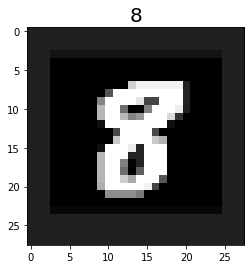

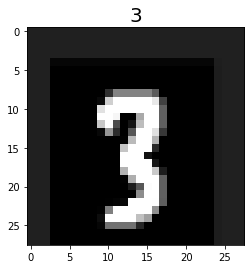

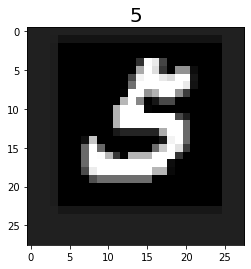

In [38]:
mnist_dataset = mnist_dataset3+mnist_dataset2+mnist_dataset1
mnist_dataset = mnist_dataset.create_dict_iterator(output_numpy=True)
data = next(mnist_dataset)
for i in range(3):
    img = data['image'][i,...].squeeze().squeeze()
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title(data['label'][i], fontsize=20)
    plt.show()

In [50]:
import mindspore.nn as nn # 各类网络层都在nn里面
from mindspore.common.initializer import Normal # 参数初始化
from mindspore.nn.metrics import Accuracy # 测试模型用
class LeNet5(nn.Cell):
    
    # 定义算子
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        
        # 全连接层
        self.fc1 = nn.Dense(4 * 4 * 16, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        
        # 激活函数
        self.relu = nn.ReLU()
        
        # 最大池化层
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 网络展开
        self.flatten = nn.Flatten()
        
    # 建构网络
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x 

In [42]:
def concat_data(path):
    mnist_dataset1 = create_aug_dataset1(path)
    mnist_dataset2 = create_aug_dataset2(path)
    mnist_dataset3 = create_aug_dataset3(path)
    mnist_dataset = mnist_dataset3+mnist_dataset2+mnist_dataset1
    return mnist_dataset
train_path = os.path.join('data','train') # 训练集路径
train_data = concat_data(train_path) # 定义训练数据集

test_path = os.path.join('data','test') # 测试集路径
test_data = concat_data(test_path) # 定义测试数据集

In [52]:
from mindspore import Model # 承载网络结构
# 网络
net = LeNet5()

# 损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 优化器
lr = 0.01
momentum = 0.9
net_opt = nn.Momentum(net.trainable_params(), lr, momentum)

# 模型
model = Model(net, net_loss, net_opt, metrics={'accuracy': Accuracy()})

In [53]:
model.train(3, train_data) # 训练3个epoch

[WARNING] ME(7200:26836,MainProcess):2021-10-24-10:19:32.690.015 [mindspore\train\model.py:412] The CPU cannot support dataset sink mode currently.So the training process will be performed with dataset not sink.


In [54]:
model.eval(test_data) # 测试网络

[WARNING] ME(7200:26836,MainProcess):2021-10-24-10:28:34.444.401 [mindspore\train\model.py:751] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


{'accuracy': 0.9445333333333333}

In [57]:
from mindspore import save_checkpoint,load_checkpoint, load_param_into_net
save_checkpoint(net,"lenet5-2.ckpt")